In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train_Data = pd.read_csv('zhengqi_train.txt',sep='\t',encoding = 'utf-8')
test_Data = pd.read_csv('zhengqi_test.txt',sep='\t',encoding = 'utf-8')

In [3]:
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.svm import LinearSVR, SVR
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import learning_curve,train_test_split,ShuffleSplit
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,ElasticNet
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor

In [4]:
def get_train_data():
    X = train_Data[train_Data.columns[:-1]]
    y = train_Data[train_Data.columns[-1]]
    X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 100)
    return  X_train ,X_test,y_train,y_test

def get_test_data():
    test = test_Data
    return test

In [5]:
"""定义评估指标函数"""
def rmse(y_true,y_pred):
    dif = y_pred-y_true
    sum_sq = sum(dif**2)
    n=len(y_pred)
    return np.sqrt(sum_sq/n)

def mse(y_true,y_pred):
    return mean_squared_error(y_true,y_pred)

rmse_scorer = make_scorer(rmse,greater_is_better = False)
mse_scorer = make_scorer(mse,greater_is_better = False)

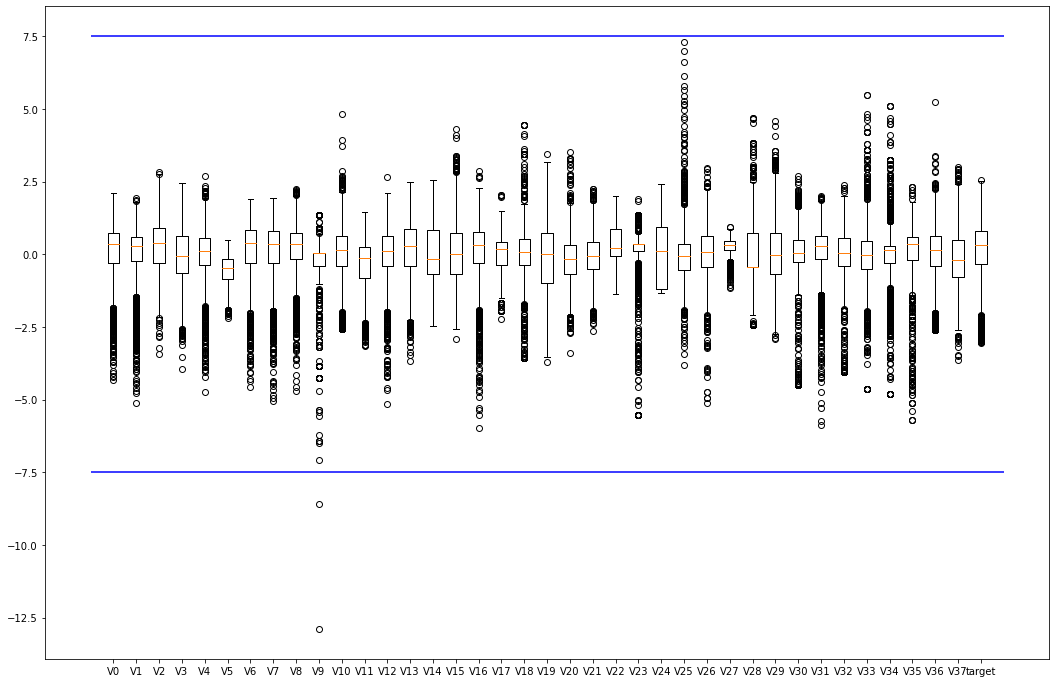

In [6]:
'''通过箱线图查看异常值'''
plt.figure(figsize=(18,12))
plt.boxplot(x = train_Data.values,labels = train_Data.columns)
plt.hlines([-7.5,7.5],0,40,colors='b')
plt.savefig('box.jpg')

In [7]:
"""删除异常值"""
train_Data = train_Data[train_Data['V9']>-7.5]
test_Data = test_Data[test_Data['V9']>-7.5]


In [8]:
'''根据之前的核密度估计，删除训练集和测试集差别较大的列'''
train_Data .drop(['V5','V9','V11','V17','V22','V28'],inplace = True,axis =1)
test_Data .drop(['V5','V9','V11','V17','V22','V28'],inplace = True,axis =1)

In [9]:
'''数据归一化处理'''
#from sklearn import preprocessing
features_columns = train_Data.columns.tolist()[:32]
min_max_scaler = MinMaxScaler()
min_max_scaler = min_max_scaler.fit(train_Data[features_columns])

In [10]:
train_data_scater = min_max_scaler.transform(train_Data[features_columns])
test_data_scater = min_max_scaler.transform(test_Data[features_columns])

In [11]:
train_data_scater = pd.DataFrame(train_data_scater,columns = features_columns)
train_data_scater['target']=train_Data['target']
test_data_scater = pd.DataFrame(test_data_scater,columns = features_columns)

mcorr.shape= (33, 33)


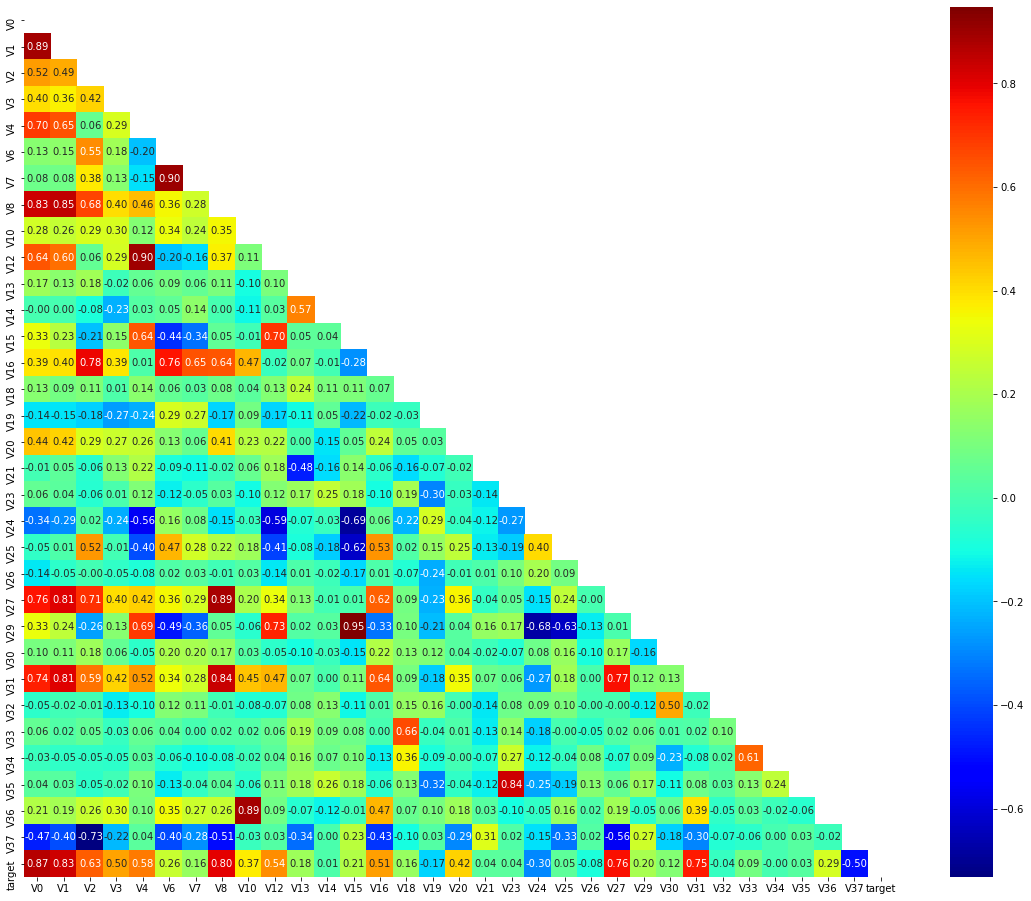

In [12]:
plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
colnm = train_Data.columns.tolist()  # 列表头
mcorr = train_Data.corr(method="spearman")  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
print('mcorr.shape=',mcorr.shape)
mask = np.zeros_like(mcorr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型
#画上三角相关系数矩阵
mask[np.triu_indices_from(mask)] = True  
g = sns.heatmap(mcorr, mask=mask, cmap=plt.cm.jet, square=True, annot=True, fmt='0.2f')  # 热力图
plt.savefig('mcorr.jpg')

In [13]:
"""移除与target相关系数绝对值小于0.1的特征变量"""
threshold = 0.1

corr_matrix = train_Data.corr().abs()
drop_col=corr_matrix[corr_matrix["target"]<threshold].index
print('drop_col=',drop_col)
train_Data.drop(drop_col,axis=1,inplace=True)
test_Data.drop(drop_col,axis=1,inplace=True)

drop_col= Index(['V14', 'V21', 'V25', 'V26', 'V32', 'V33', 'V34'], dtype='object')


In [14]:
'''下面的代码也可以实现异常值检测与剔除'''


'''
# 查找异常值

ridge = RidgeCV(alphas=[0.0001,0.001,0.01,0.1,0.2,0.5,1,2,3,4,5,10,20,30,50])

X_train = train_Data.iloc[:,:-2]

y_train = train_Data['target'] #真实值

ridge.fit(X_train,y_train)  # 算法拟合数据，结果不可能100%完全拟合

#进行数据预测，与真实值进行比较，将差距大的值进行筛选，删除
y_ = ridge.predict(X_train)  #预测值


cond = (y_train - y_).abs() > y_train.std() * 0.9


plt.figure(figsize=(12,6))

axes = plt.subplot(1,3,1)
axes.scatter(y_train,y_)
axes.scatter(y_train[cond],y_[cond],c = 'red',s = 20)

axes = plt.subplot(1,3,2)
axes.scatter(y_train,y_train - y_)
axes.scatter(y_train[cond],(y_train - y_)[cond],c = 'red',s = 20)

axes = plt.subplot(1,3,3)
(y_train - y_).plot.hist(bins = 50,ax = axes)
(y_train - y_).loc[cond].plot.hist(bins = 50,ax = axes,color = 'red')

plt.savefig('异常值.jpg')

# 将异常值过滤
drop_index = cond[cond].index

train_Data.drop(drop_index,axis = 0,inplace=True)
test_Data.drop(drop_index,axis = 0,inplace=True)
'''

"\n# 查找异常值\n\nridge = RidgeCV(alphas=[0.0001,0.001,0.01,0.1,0.2,0.5,1,2,3,4,5,10,20,30,50])\n\nX_train = train_Data.iloc[:,:-2]\n\ny_train = train_Data['target'] #真实值\n\nridge.fit(X_train,y_train)  # 算法拟合数据，结果不可能100%完全拟合\n\n#进行数据预测，与真实值进行比较，将差距大的值进行筛选，删除\ny_ = ridge.predict(X_train)  #预测值\n\n\ncond = (y_train - y_).abs() > y_train.std() * 0.9\n\n\nplt.figure(figsize=(12,6))\n\naxes = plt.subplot(1,3,1)\naxes.scatter(y_train,y_)\naxes.scatter(y_train[cond],y_[cond],c = 'red',s = 20)\n\naxes = plt.subplot(1,3,2)\naxes.scatter(y_train,y_train - y_)\naxes.scatter(y_train[cond],(y_train - y_)[cond],c = 'red',s = 20)\n\naxes = plt.subplot(1,3,3)\n(y_train - y_).plot.hist(bins = 50,ax = axes)\n(y_train - y_).loc[cond].plot.hist(bins = 50,ax = axes,color = 'red')\n\nplt.savefig('异常值.jpg')\n\n# 将异常值过滤\ndrop_index = cond[cond].index\n\ntrain_Data.drop(drop_index,axis = 0,inplace=True)\ntest_Data.drop(drop_index,axis = 0,inplace=True)\n"

In [15]:
"""异常值检测函数"""
def find_outliers(model, X, y, sigma=3):
    '''返回通过模型回归得到的y_pre'''
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    #"""如果回归失败，再尝试拟合"""
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)
 
    '''计算残差'''
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
 
    '''将残差进行Z-zero标准化'''
    z = (resid - mean_resid) / std_resid
    '''判断z是否大于3'''
    outliers = abs(z) > sigma
 
    '''返回拟合得分、mse、rmse'''
    print('score=', model.score(X, y))
    print('rmse=', rmse(y, y_pred))
    print("mse=", mean_squared_error(y, y_pred))
    print('---------------------------------------')
    
    '''残差平均值和方差'''
    print('mean of residuals:', mean_resid)
    print('std of residuals:', std_resid)
    print('---------------------------------------')
    
    '''显示异常值个数以及索引'''
    print(len(outliers[outliers]), 'outliers:')
    print(outliers[outliers].index)
    
    '''在真实值与测试值的散点图中显示异常值'''
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(y, y_pred, '.')#正常值
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')#显示异常值
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    '''残差与真实值的散点图中显示异常值'''
    plt.subplot(1, 3, 2)
    plt.plot(y, y - y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    
    '''显示的z>3的异常值'''
    plt.subplot(1, 3, 3)
    plt.hist(z,bins=50)
    plt.hist(z.loc[outliers],color='r', bins=50)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('normal res error')
    plt.ylabel('frequency')
 
    plt.savefig('异常值.jpg')
    return outliers

score= 0.8815094884986125
rmse= 0.33836367284059304
mse= 0.11448997509817599
---------------------------------------
mean of residuals: -1.3964343656927645e-17
std of residuals: 0.3384223096442289
---------------------------------------
33 outliers:
Int64Index([ 321,  348,  376,  777,  843,  884, 1046, 1069, 1145, 1164, 1310,
            1458, 1523, 1537, 1704, 1874, 1979, 2002, 2159, 2264, 2279, 2620,
            2645, 2647, 2667, 2668, 2669, 2696, 2767, 2769, 2807, 2842, 2863],
           dtype='int64')


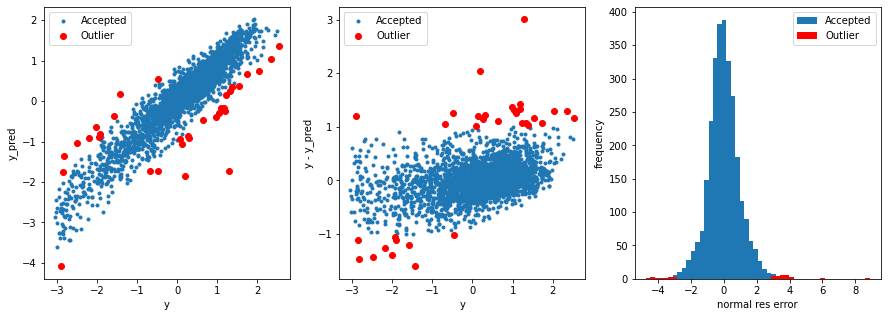

In [16]:
# get training data
from sklearn.linear_model import Ridge
X_train = train_Data.iloc[:,0:-2]
y_train = train_Data.iloc[:,-1]
# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

In [17]:
drop_index = outliers[outliers].index
train_Data.drop(drop_index,axis = 0,inplace=True)

In [18]:
X_train, X_valid,y_train,y_valid = get_train_data()

In [19]:
def get_trainning_data_omitoutliers():
    X1=X_train.copy()
    y1=y_train.copy()
    return X1,y1

In [20]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    '''获取未修改的训练数据，除非要使用的数据已经指定'''
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()

    
    '''K折交叉验证'''
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    '''如果给定param_grid，执行网格搜索'''
    if len(param_grid)>0:
        '''设置网格搜索参数'''
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        '''搜索'''
        gsearch.fit(X,y)

        '''从网格中提取最佳模型'''
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        '''获得得分最好的参数'''
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    #'''如果未给定，只对模型进行评分'''  
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    '''将均值和方差结合到Series中'''
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    '''预测'''
    y_pred = model.predict(X)
    
    '''打印模型得分'''        
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    '''残差以及z-zero标准化'''
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    '''预测值和真实值的散点图，标题为真实值和预测值的相关性'''
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    
    '''残差和真实值的散点图，标题为残差的标准差'''
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    '''残差以及z-zero标准化'''
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

opt_models = dict()#储存模型及其参数
score_models = pd.DataFrame(columns=['mean','std'])

# K折
splits=5
# 重复次数
repeats=5

In [21]:
'''测试不同模型回归效果'''

'测试不同模型回归效果'

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    9.3s finished


----------------------
Ridge(alpha=0.25)
----------------------
score= 0.9020598702767281
rmse= 0.30345626310237733
mse= 0.09208570361605908
cross_val: mean= 0.09553795765272395 , std= 0.0048876665016024355


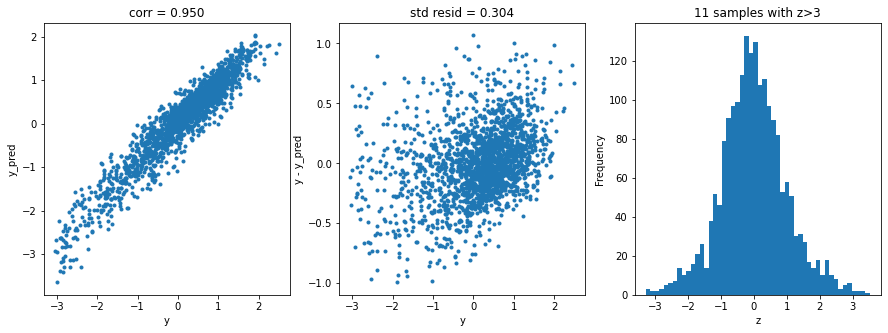

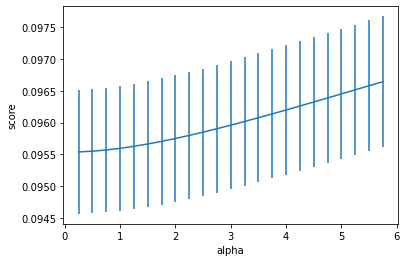

In [22]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')
plt.savefig('Ridge.jpg')

岭回归的结果显示，预测值和真实值的相关性为0.950，高度相关；残差标准差为0.304，有11个经过z-zero标准化的残差$z_i>3$  
MSE = 0.09209,score在$[0,6]$范围内随着$\alpha$增加而增加

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   19.7s finished


----------------------
Lasso(alpha=0.0003400000000000001)
----------------------
score= 0.9020111173583091
rmse= 0.3035317813697181
mse= 0.09213154230147469
cross_val: mean= 0.09561929393239879 , std= 0.007129155764603151


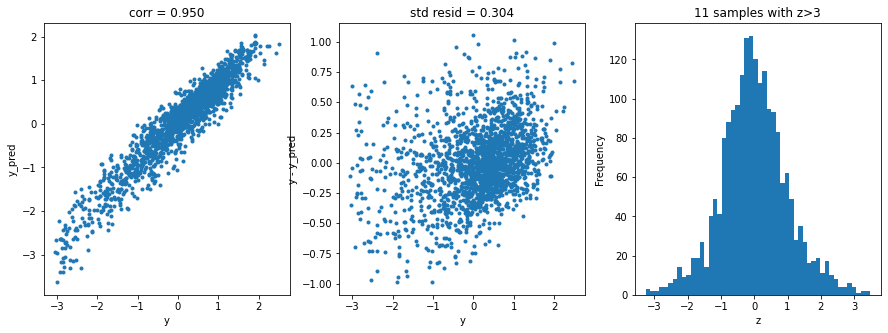

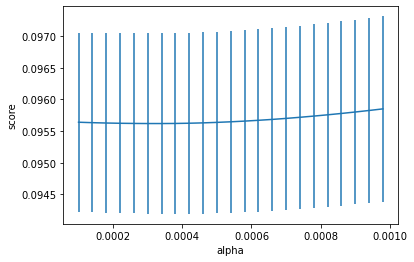

In [23]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')
plt.savefig('Lasso.jpg')

Lasso回归的结果显示，预测值和真实值的相关性为0.950，高度相关；残差标准差为0.304，有11个经过z-zero标准化的残差$z_i>3$  
MSE = 0.09213，score在$[0.0002,0.0010]$范围内随着$\alpha$增加而增加

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   15.2s finished


----------------------
ElasticNet(alpha=0.0002, l1_ratio=0.9, max_iter=100000)
----------------------
score= 0.9020466758996937
rmse= 0.30347670304624136
mse= 0.09209810929181655
cross_val: mean= 0.09616949800331856 , std= 0.0028068549669226007


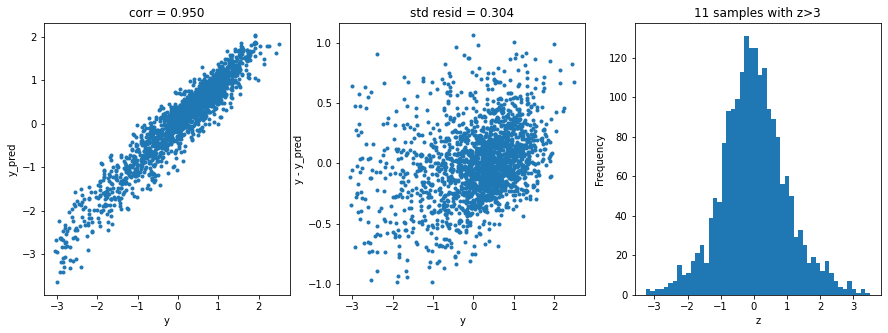

In [24]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)
plt.savefig('ElasticNet.jpg')

ElasticNet回归的结果显示，预测值和真实值的相关性为0.950，高度相关；残差标准差为0.304，有11个经过z-zero标准化的残差$z_i>3$  
MSE =0.09210。

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   18.2s finished


----------------------
LinearSVR(C=0.5)
----------------------
score= 0.9006892264095082
rmse= 0.3055722770122708
mse= 0.09337441647846387
cross_val: mean= 0.09624179036372697 , std= 0.007285737605615533


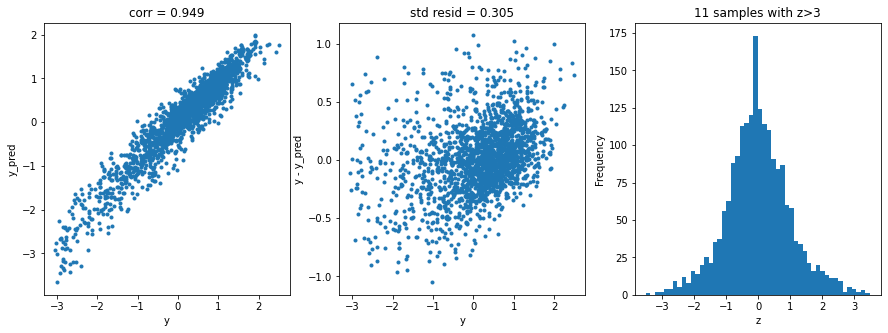

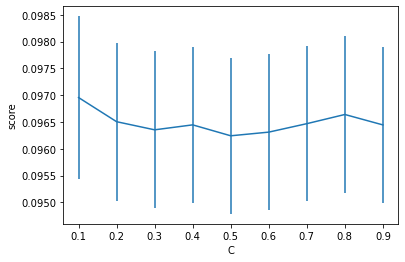

In [25]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange,
             'max_iter':[1000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)


cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score')
plt.savefig('LinearSVR.jpg')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   11.4s finished


----------------------
KNeighborsRegressor(n_neighbors=8)
----------------------
score= 0.8831121982857114
rmse= 0.331512847265159
mse= 0.10990076790185278
cross_val: mean= 0.15104130119801457 , std= 0.011372940536876451


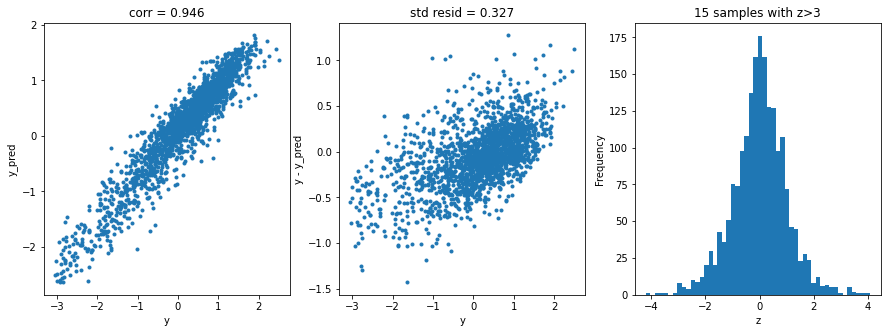

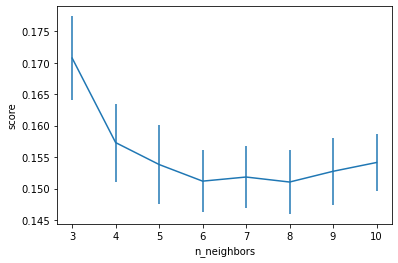

In [26]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*1))
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.savefig('KNeighbors.jpg')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  7.3min finished


----------------------
GradientBoostingRegressor(min_samples_split=5, n_estimators=250)
----------------------
score= 0.9655406696827402
rmse= 0.17999862373924552
mse= 0.032399504548022484
cross_val: mean= 0.1004376751445228 , std= 0.005770596428246196


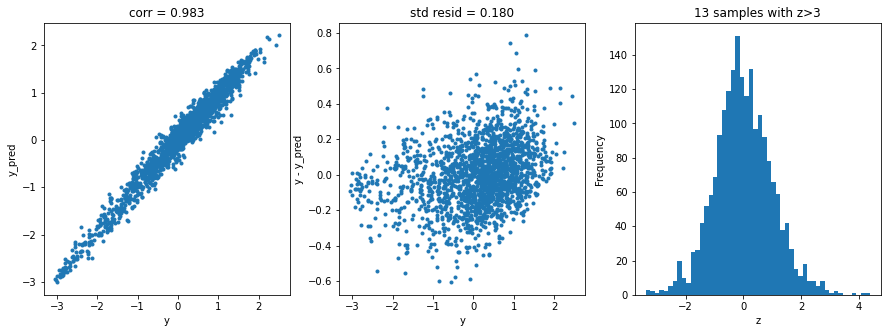

In [27]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[150,250,350],
              'max_depth':[1,2,3],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)
plt.savefig('GradientBoosting.jpg')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   42.8s finished


----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
----------------------
score= 0.9572922161006335
rmse= 0.20038688130108367
mse= 0.04015490219757463
cross_val: mean= 0.10598639493486162 , std= 0.011090844561810533


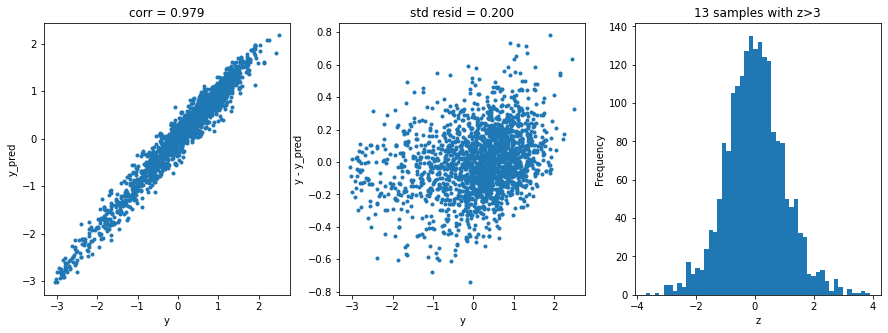

In [28]:
model = 'XGB'
opt_models[model] = xgb.XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)
plt.savefig('XGB.jpg')

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed: 14.3min finished


----------------------
RandomForestRegressor(max_features=12, n_estimators=200)
----------------------
score= 0.9849647812538888
rmse= 0.11889693067879116
mse= 0.014136480124837267
cross_val: mean= 0.10350161210861653 , std= 0.0070484730205086065


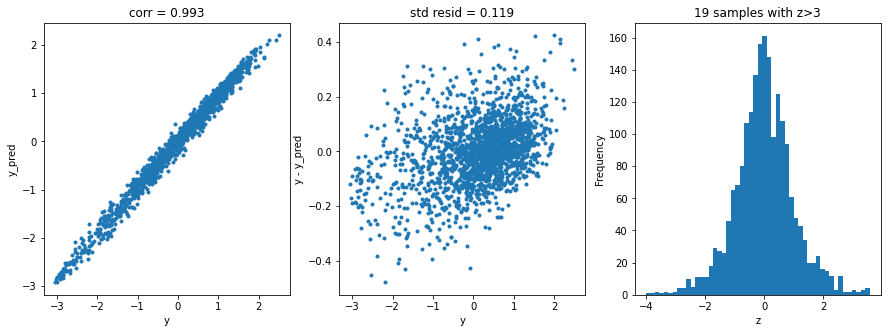

In [29]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[8,12,16,20,24],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)
plt.savefig('RandomForest.jpg')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   12.4s finished


----------------------
LGBMRegressor()
----------------------
score= 0.9862973048455709
rmse= 0.11350598608509586
mse= 0.012883608877150015
cross_val: mean= 0.09658451418251275 , std= 0.006329116894800156


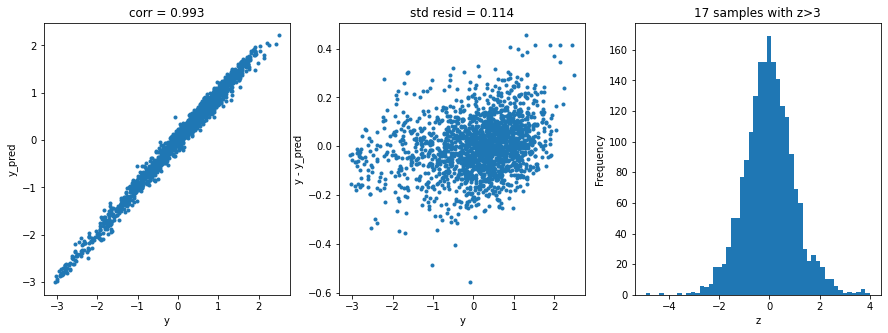

In [30]:
model = 'LGB'
opt_models[model] = lgb.LGBMRegressor()

param_grid = {'learning_rate':[0.01,0.1,1],
              'n_estimators':[50,100],}
opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)
plt.savefig('LGB.jpg')

使用LGB模型

In [33]:
clf = lgb.LGBMRegressor(learning_rate=0.01,max_depth=-1,
                        n_estimators = 100,boosting_type='gbdt',
                        random_state=2000,objective = 'regression',
                       num_leaves = 30)

clf.fit(X=X_train,y=y_train,eval_metric='MSE',verbose=50)
target_pred = clf.predict(test_Data)


In [34]:
target_pred = pd.DataFrame(data = target_pred)

In [35]:
target_pred.to_csv('target_pred.txt',header=False,index=False )